In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Data Exploration


In [2]:
data=pd.read_csv('regenerated_landslide_risk_dataset.csv')

In [3]:
data['Landslide Risk Prediction'].value_counts()

Landslide Risk Prediction
Low          4591
Moderate      334
High           63
Very High      12
Name: count, dtype: int64

In [4]:
data['Landslide Risk Prediction']= data['Landslide Risk Prediction'].map({'High': 2, 'Low': 0, 'Moderate': 1, 'Very High':3})

In [5]:
data.corr() #Correlation analysis of different features

,Temperature (°C),Humidity (%),Precipitation (mm),Soil Moisture (%),Elevation (m),Landslide Risk Prediction
Temperature (°C),1.000000,-0.006419,-0.006119,-0.002273,-0.034350,0.007763
Humidity (%),-0.006419,1.000000,-0.033448,0.003067,0.013448,0.309777
Precipitation (mm),-0.006119,-0.033448,1.000000,-0.003067,-0.000353,0.177210
Soil Moisture (%),-0.002273,0.003067,-0.003067,1.000000,0.013021,0.295081
Elevation (m),-0.034350,0.013448,-0.000353,0.013021,1.000000,0.115451
Landslide Risk Prediction,0.007763,0.309777,0.177210,0.295081,0.115451,1.000000


In [6]:
sensor_data= data.drop(['Precipitation (mm)'],axis=1)

In [7]:
sensor_data.head()

,Temperature (°C),Humidity (%),Soil Moisture (%),Elevation (m),Landslide Risk Prediction
0,17,68,64,120,0
1,26,33,24,672,0
2,16,81,52,36,0
3,25,53,70,583,0
4,34,77,37,130,0


In [8]:
skf= StratifiedKFold(n_splits=5, shuffle= True, random_state=42)

x= data.drop(['Landslide Risk Prediction'], axis=1)
y= data['Landslide Risk Prediction']

In [9]:
for train_index, test_index in skf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
def map(cm):   
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(y)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)


    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Training all features on XGBoost

In [11]:
skf= StratifiedKFold(n_splits=5, shuffle= True, random_state=2)

s_x= sensor_data.drop(['Landslide Risk Prediction'], axis=1)
s_y= sensor_data['Landslide Risk Prediction']

In [12]:
for train_index, test_index in skf.split(x, y):
    s_x_train, s_x_test = s_x.iloc[train_index], s_x.iloc[test_index]
    s_y_train, s_y_test = s_y.iloc[train_index], s_y.iloc[test_index]

In [13]:
import xgboost as xgb

In [14]:
model = xgb.XGBClassifier(n_estimators=1, max_depth=7, learning_rate=0.1, n_jobs=-1)

In [15]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
y_pred= model.predict(x_test)   

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       918
           1       1.00      0.99      0.99        67
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         3

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [18]:
cm=confusion_matrix(y_test, y_pred)

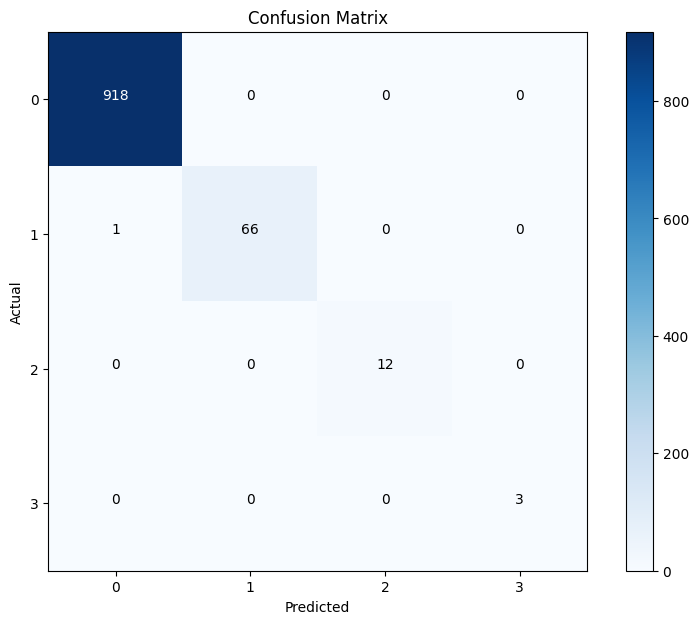

In [19]:
map(cm)

In [20]:
model.save_model('all_features_model.json')

# Training all features on LogisticRegression

In [250]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)
y_pred_prob = model.predict_proba(x_test)

y_pred = np.argmax(y_pred_prob, axis=1)




c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [251]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       918
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         3

    accuracy                           0.92      1000
   macro avg       0.23      0.25      0.24      1000
weighted avg       0.84      0.92      0.88      1000



c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

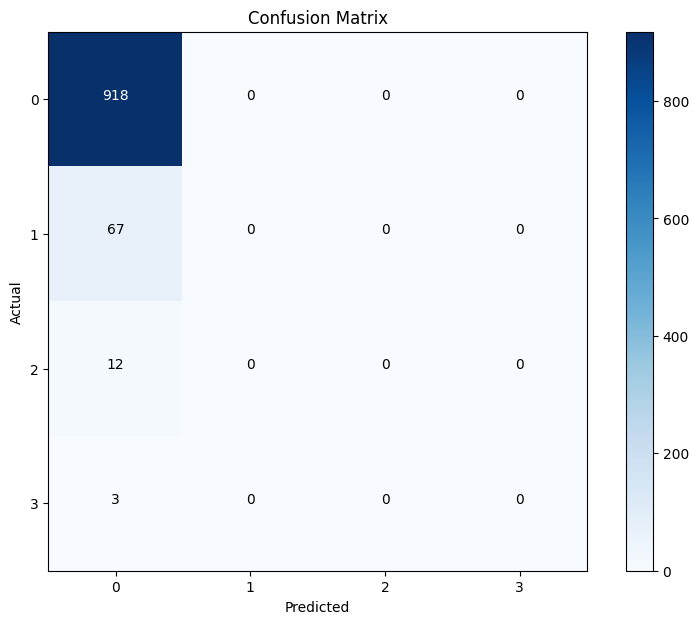

In [252]:
cm= confusion_matrix(y_test, y_pred)
map(cm)

# Training using SVC Classifier

In [253]:
from sklearn.svm import SVC

In [254]:
model= SVC()
model.fit(x_train, y_train)
y_pred= model.predict(x_test)


In [255]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       918
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         3

    accuracy                           0.92      1000
   macro avg       0.23      0.25      0.24      1000
weighted avg       0.84      0.92      0.88      1000



c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\roshni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

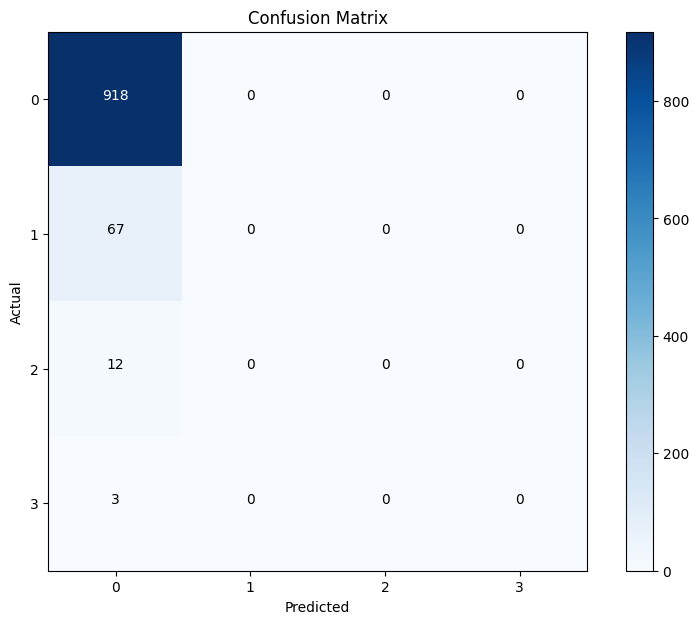

In [256]:
cm= confusion_matrix(y_test, y_pred)
map(cm)

# Training on soil Moisture,Humidity, Temperature and elevation

In [257]:
import xgboost as xgb

In [258]:
s_x= sensor_data.drop(['Landslide Risk Prediction'], axis=1)
s_y= sensor_data['Landslide Risk Prediction']

In [259]:
s_x.head()

,Temperature (°C),Humidity (%),Soil Moisture (%),Elevation (m)
0,17,68,64,120
1,26,33,24,672
2,16,81,52,36
3,25,53,70,583
4,34,77,37,130


In [260]:
for train_index, test_index in skf.split(s_x, s_y):
    s_x_train, s_x_test = s_x.iloc[train_index], s_x.iloc[test_index]
    s_y_train, s_y_test = s_y.iloc[train_index], s_y.iloc[test_index] 

In [261]:
sensor_model= xgb.XGBClassifier(n_estimators=1, max_depth=7, learning_rate=0.1, n_jobs=-1)


In [262]:
sensor_model.fit(s_x_train, s_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [263]:
feature_importances = sensor_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': s_x_test.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importances_df)

             Feature  Importance
2  Soil Moisture (%)    0.526475
1       Humidity (%)    0.252823
3      Elevation (m)    0.201716
0   Temperature (°C)    0.018986


In [271]:
s_x_train.head()

,Temperature (°C),Humidity (%),Soil Moisture (%),Elevation (m)
0,17,68,64,120
1,26,33,24,672
2,16,81,52,36
3,25,53,70,583
4,34,77,37,130


In [265]:
s_y_pred= sensor_model.predict(s_x_test)

In [266]:
print(classification_report(s_y_test, s_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       918
           1       0.56      0.78      0.65        67
           2       0.29      0.42      0.34        12
           3       0.67      0.67      0.67         3

    accuracy                           0.93      1000
   macro avg       0.63      0.70      0.66      1000
weighted avg       0.94      0.93      0.93      1000



In [267]:
cm=confusion_matrix(s_y_test, s_y_pred)

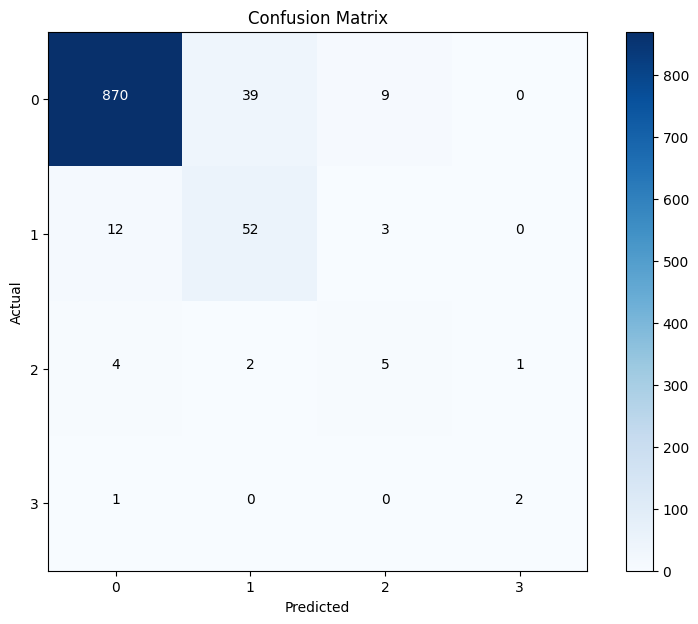

In [268]:
map(cm)

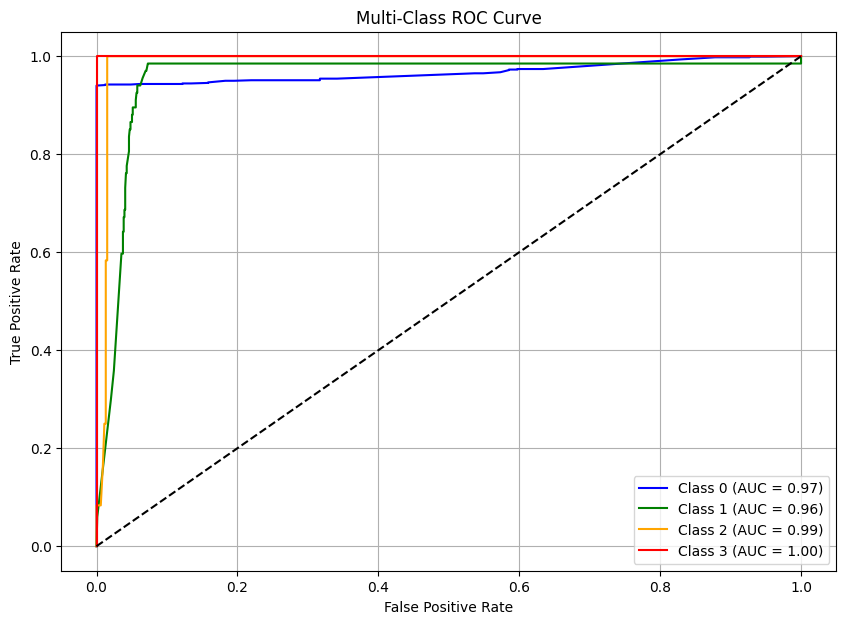

In [269]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
num_classes=4

y_test = s_y_test
y_pred_proba = sensor_model.predict_proba(s_x_test)

y_test_onehot = label_binarize(y_test, classes=[0, 1, 2, 3])

plt.figure(figsize=(10, 7))

colors = ['blue', 'green', 'orange', 'red']

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i], label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')  # ROC curve for random model is a diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [270]:
sensor_model.save_model('final_model.json')

In [277]:
import numpy as np
import pandas as pd

# Assuming y_test, y_pred, and x_test are already defined
# y_test and y_pred should be numpy arrays or pandas Series
# x_test should be a pandas DataFrame

# Convert y_test and y_pred to numpy arrays if they are not already
s_y_test = np.array(s_y_test)
s_y_pred = np.array(s_y_pred)

# Find indices where y_test and y_pred are equal and belong to class 1 or class 2
# indices_class_1 = np.where((s_y_test == s_y_pred) & (s_y_test == 1))[0]
indices_class_2 = np.where((s_y_test == s_y_pred) & (s_y_test == 2))[0]

# Combine the indices
# indices = np.concatenate((indices_class_1, indices_class_2))

# Filter x_test using the identified indices
filtered_x_test = s_x_test.iloc[indices_class_2]

# Display the filtered x_test values
print(filtered_x_test)

      Temperature (°C)  Humidity (%)  Soil Moisture (%)  Elevation (m)
78                  35            88                 89            958
143                 28            88                 78            765
1115                33            95                 84            627
1582                25            95                 79            439
4891                15            91                 79            700
